In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression, ElasticNet, Lasso, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
import lightgbm as lgb
from sklearn.model_selection import TimeSeriesSplit
from tqdm import tqdm

from sklearn import metrics

# 한글폰트 설정
plt.rc('font', family='NanumBarunGothic')

In [2]:
import torch
torch.cuda.is_available()
torch.cuda.get_device_name(0)

'NVIDIA GeForce RTX 3090'

In [3]:
data_root = '/root/ML-Regression/Competition/data/'
train_df = pd.read_csv(data_root + 'train.csv')
test_df = pd.read_csv(data_root + 'test.csv')
birth_rate_df = pd.read_csv(data_root + 'Seoul_BirthRate.csv')

/tmp/ipykernel_133803/2018899897.py:2: DtypeWarning: Columns (16,17,36) have mixed types. Specify dtype option on import or set low_memory=False.
  train_df = pd.read_csv(data_root + 'train.csv')


In [4]:
train_df.head()

,시군구,번지,본번,부번,아파트명,전용면적(㎡),계약년월,계약일,층,건축년도,...,건축면적,주차대수,기타/의무/임대/임의=1/2/3/4,단지승인일,사용허가여부,관리비 업로드,좌표X,좌표Y,단지신청일,target
0,서울특별시 강남구 개포동,658-1,658.0,1.0,개포6차우성,79.97,201712,8,3,1987,...,4858.0,262.0,임의,2022-11-17 13:00:29.0,Y,N,127.05721,37.476763,2022-11-17 10:19:06.0,124000
1,서울특별시 강남구 개포동,658-1,658.0,1.0,개포6차우성,79.97,201712,22,4,1987,...,4858.0,262.0,임의,2022-11-17 13:00:29.0,Y,N,127.05721,37.476763,2022-11-17 10:19:06.0,123500
2,서울특별시 강남구 개포동,658-1,658.0,1.0,개포6차우성,54.98,201712,28,5,1987,...,4858.0,262.0,임의,2022-11-17 13:00:29.0,Y,N,127.05721,37.476763,2022-11-17 10:19:06.0,91500
3,서울특별시 강남구 개포동,658-1,658.0,1.0,개포6차우성,79.97,201801,3,4,1987,...,4858.0,262.0,임의,2022-11-17 13:00:29.0,Y,N,127.05721,37.476763,2022-11-17 10:19:06.0,130000
4,서울특별시 강남구 개포동,658-1,658.0,1.0,개포6차우성,79.97,201801,8,2,1987,...,4858.0,262.0,임의,2022-11-17 13:00:29.0,Y,N,127.05721,37.476763,2022-11-17 10:19:06.0,117000


In [5]:
# 시, 군, 구 분리
train_df['시'] = train_df['시군구'].apply(lambda x: x.split()[0])
train_df['구'] = train_df['시군구'].apply(lambda x: x.split()[1])
train_df['동'] = train_df['시군구'].apply(lambda x: x.split()[2])
test_df['시'] = test_df['시군구'].apply(lambda x: x.split()[0])
test_df['구'] = test_df['시군구'].apply(lambda x: x.split()[1])
test_df['동'] = test_df['시군구'].apply(lambda x: x.split()[2])

In [6]:
train_df.isnull().sum()

시군구                             0
번지                            225
본번                             75
부번                             75
아파트명                         2126
전용면적(㎡)                         0
계약년월                            0
계약일                             0
층                               0
건축년도                            0
도로명                             0
해제사유발생일                   1112839
등기신청일자                          0
거래유형                            0
중개사소재지                          0
k-단지분류(아파트,주상복합등등)         870691
k-전화번호                     870274
k-팩스번호                     872742
단지소개기존clob                1050240
k-세대타입(분양형태)               869563
k-관리방식                     869563
k-복도유형                     869890
k-난방방식                     869563
k-전체동수                     870630
k-전체세대수                    869563
k-건설사(시공사)                 871058
k-시행사                      871254
k-사용검사일-사용승인일              869696
k-연면적                      869563
k-주거전용면적      

In [7]:
# 결측치 백분율로 표시
percent = train_df.isnull().sum() / len(train_df) * 100
pd.DataFrame({'percent': percent}).sort_values('percent', ascending=False)

,percent
k-135㎡초과,99.970773
해제사유발생일,99.465241
k-등록일자,99.017717
단지소개기존clob,93.870160
k-홈페이지,89.884450
고용보험관리번호,81.630858
세대전기계약방법,78.542163
k-팩스번호,78.005438
k-시행사,77.872441
청소비관리형태,77.865648


In [8]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
train_df.tail(20)

,시군구,번지,본번,부번,아파트명,전용면적(㎡),계약년월,계약일,층,건축년도,도로명,해제사유발생일,등기신청일자,거래유형,중개사소재지,"k-단지분류(아파트,주상복합등등)",k-전화번호,k-팩스번호,단지소개기존clob,k-세대타입(분양형태),k-관리방식,k-복도유형,k-난방방식,k-전체동수,k-전체세대수,k-건설사(시공사),k-시행사,k-사용검사일-사용승인일,k-연면적,k-주거전용면적,k-관리비부과면적,k-전용면적별세대현황(60㎡이하),k-전용면적별세대현황(60㎡~85㎡이하),k-85㎡~135㎡이하,k-135㎡초과,k-홈페이지,k-등록일자,k-수정일자,고용보험관리번호,경비비관리형태,세대전기계약방법,청소비관리형태,건축면적,주차대수,기타/의무/임대/임의=1/2/3/4,단지승인일,사용허가여부,관리비 업로드,좌표X,좌표Y,단지신청일,target,시,구,동
1118802,서울특별시 은평구 구산동,382,382.0,0.0,갈현현대,59.94,200704,5,10,1998,서오릉로21길 36,NaN,,-,-,아파트,23547358.0,23529429.0,NaN,분양,위탁관리,혼합식,개별난방,4.0,366.0,현대건설,갈현아파트재건축조합,1998-11-28 00:00:00.0,45515.0,28335.0,28335.0,171.0,141.0,54.0,NaN,NaN,NaN,2023-09-26 07:15:20.0,911-01-25120-1,위탁,종합계약,위탁,0.0,366.0,의무,2013-06-04 16:18:51.0,Y,N,126.905638,37.612962,2013-03-07 09:46:27.0,14800,서울특별시,은평구,구산동
1118803,서울특별시 은평구 구산동,382,382.0,0.0,갈현현대,84.83,200704,15,4,1998,서오릉로21길 36,NaN,,-,-,아파트,23547358.0,23529429.0,NaN,분양,위탁관리,혼합식,개별난방,4.0,366.0,현대건설,갈현아파트재건축조합,1998-11-28 00:00:00.0,45515.0,28335.0,28335.0,171.0,141.0,54.0,NaN,NaN,NaN,2023-09-26 07:15:20.0,911-01-25120-1,위탁,종합계약,위탁,0.0,366.0,의무,2013-06-04 16:18:51.0,Y,N,126.905638,37.612962,2013-03-07 09:46:27.0,27000,서울특별시,은평구,구산동
1118804,서울특별시 은평구 구산동,382,382.0,0.0,갈현현대,53.54,200704,16,8,1998,서오릉로21길 36,NaN,,-,-,아파트,23547358.0,23529429.0,NaN,분양,위탁관리,혼합식,개별난방,4.0,366.0,현대건설,갈현아파트재건축조합,1998-11-28 00:00:00.0,45515.0,28335.0,28335.0,171.0,141.0,54.0,NaN,NaN,NaN,2023-09-26 07:15:20.0,911-01-25120-1,위탁,종합계약,위탁,0.0,366.0,의무,2013-06-04 16:18:51.0,Y,N,126.905638,37.612962,2013-03-07 09:46:27.0,12700,서울특별시,은평구,구산동
1118805,서울특별시 은평구 구산동,382,382.0,0.0,갈현현대,53.54,200704,17,10,1998,서오릉로21길 36,NaN,,-,-,아파트,23547358.0,23529429.0,NaN,분양,위탁관리,혼합식,개별난방,4.0,366.0,현대건설,갈현아파트재건축조합,1998-11-28 00:00:00.0,45515.0,28335.0,28335.0,171.0,141.0,54.0,NaN,NaN,NaN,2023-09-26 07:15:20.0,911-01-25120-1,위탁,종합계약,위탁,0.0,366.0,의무,2013-06-04 16:18:51.0,Y,N,126.905638,37.612962,2013-03-07 09:46:27.0,13000,서울특별시,은평구,구산동
1118806,서울특별시 은평구 구산동,382,382.0,0.0,갈현현대,59.94,200704,23,3,1998,서오릉로21길 36,NaN,,-,-,아파트,23547358.0,23529429.0,NaN,분양,위탁관리,혼합식,개별난방,4.0,366.0,현대건설,갈현아파트재건축조합,1998-11-28 00:00:00.0,45515.0,28335.0,28335.0,171.0,141.0,54.0,NaN,NaN,NaN,2023-09-26 07:15:20.0,911-01-25120-1,위탁,종합계약,위탁,0.0,366.0,의무,2013-06-04 16:18:51.0,Y,N,126.905638,37.612962,2013-03-07 09:46:27.0,15300,서울특별시,은평구,구산동
1118807,서울특별시 은평구 구산동,382,382.0,0.0,갈현현대,59.94,200705,8,1,1998,서오릉로21길 36,NaN,,-,-,아파트,23547358.0,23529429.0,NaN,분양,위탁관리,혼합식,개별난방,4.0,366.0,현대건설,갈현아파트재건축조합,1998-11-28 00:00:00.0,45515.0,28335.0,28335.0,171.0,141.0,54.0,NaN,NaN,NaN,2023-09-26 07:15:20.0,911-01-25120-1,위탁,종합계약,위탁,0.0,366.0,의무,2013-06-04 16:18:51.0,Y,N,126.905638,37.612962,2013-03-07 09:46:27.0,14200,서울특별시,은평구,구산동
1118808,서울특별시 은평구 구산동,382,382.0,0.0,갈현현대,114.95,200705,8,4,1998,서오릉로21길 36,NaN,,-,-,아파트,23547358.0,23529429.0,NaN,분양,위탁관리,혼합식,개별난방,4.0,366.0,현대건설,갈현아파트재건축조합,1998-11-28 00:00:00.0,45515.0,28335.0,28335.0,171.0,141.0,54.0,NaN,NaN,NaN,2023-09-26 07:15:20.0,911-01-25120-1,위탁,종합계약,위탁,0.0,366.0,의무,2013-06-04 16:18:51.0,Y,N,126.905638,37.612962,2013-03-07 09:46:27.0,35000,서울특별시,은평구,구산동
1118809,서울특별시 은평구 구산동,382,382.0,0.0,갈현현대,59.94,200705,10,6,1998,서오릉로21길 36,NaN,,-,-,아파트,23547358.0,23529429.0,NaN,분양,위탁관리,혼합식,개별난방,4.0,366.0,현대건설,갈현아파트재건축조합,1998-11-28 00:00:00.0,45515.0,28335.0,28335.0,171.0,141.0,54.0,NaN,NaN,NaN,2023-09-26 07:15:20.0,911-01-25120-1,위탁,종합계약,위탁,0.0,366.0,의무,2013-06-04 16:18:51.0,Y,N,126.905638,37.612962,2013-03-07 09:46:27.0,16500,서울특별시,은평구,구산동
1118810,서울특별시 은평구 구산동,382,382.0,0.0,갈현현대,53.54,200705,15,1,1998,서오릉로21길 36,NaN,,-,-,아파트,23547358.0,23529429.0,NaN,분양,위탁관리,혼합식,개별난방,4.0,366.0,현대건설,갈현아파트재건축조합,1998-11-28 00:00:00.0,45515.0,28335.0,28335.0,171.0,141.0,54.0,NaN,NaN,NaN,2023-09-26 07:15:20.0,911-01-25120-1,위탁,종합계약,위탁,0.0,366.0,의무,2013-06-04 16:18:51.0,Y,N,126.905638,37.612962,2013-03-07 09:46:27.0,12000,서울특별시,은평구,구산동
1118811,서울특별시 은평구 구산동,382,382.0,0.0,갈현현대,84.83,200705,23,9,1998,서오릉로21길 36,NaN,,-,-,아파트,23547358.0,23529429.0,NaN,분양,위탁관리,혼합식,개별난방,4.0,366.0

In [9]:
# 번호, 홈페이지는 아파트 가격 예측에 유의미 하지않다고 판단
train_df.drop(['k-전화번호', 'k-팩스번호', '고용보험관리번호', 'k-홈페이지'], axis=1, inplace=True)

In [10]:
# Nan 혹은 '-'으로 데이터가 처리되어 필요없다고 판단
train_df.drop(['등기신청일자', '거래유형', '중개사소재지'], axis=1, inplace=True)

In [11]:
# 결측치가 100만개 이상인 변수들 확인
print('* 결측치가 100만개 이하인 변수들 :', list(train_df.columns[train_df.isnull().sum() <= 1000000]))
print('* 결측치가 100만개 이상인 변수들 :', list(train_df.columns[train_df.isnull().sum() >= 1000000]))

* 결측치가 100만개 이하인 변수들 : ['시군구', '번지', '본번', '부번', '아파트명', '전용면적(㎡)', '계약년월', '계약일', '층', '건축년도', '도로명', 'k-단지분류(아파트,주상복합등등)', 'k-세대타입(분양형태)', 'k-관리방식', 'k-복도유형', 'k-난방방식', 'k-전체동수', 'k-전체세대수', 'k-건설사(시공사)', 'k-시행사', 'k-사용검사일-사용승인일', 'k-연면적', 'k-주거전용면적', 'k-관리비부과면적', 'k-전용면적별세대현황(60㎡이하)', 'k-전용면적별세대현황(60㎡~85㎡이하)', 'k-85㎡~135㎡이하', 'k-수정일자', '경비비관리형태', '세대전기계약방법', '청소비관리형태', '건축면적', '주차대수', '기타/의무/임대/임의=1/2/3/4', '단지승인일', '사용허가여부', '관리비 업로드', '좌표X', '좌표Y', '단지신청일', 'target', '시', '구', '동']
* 결측치가 100만개 이상인 변수들 : ['해제사유발생일', '단지소개기존clob', 'k-135㎡초과', 'k-등록일자']


In [12]:
# 결측치가 100만개 이상인 변수들 제거
train_df.drop(['해제사유발생일', '단지소개기존clob', 'k-135㎡초과', 'k-등록일자'], axis=1, inplace=True)

In [13]:
test_df.drop(['k-전화번호', 'k-팩스번호', '고용보험관리번호', '등기신청일자', '거래유형', '중개사소재지', 'k-홈페이지', '해제사유발생일', '단지소개기존clob', 'k-135㎡초과', 'k-등록일자'], axis=1, inplace=True)

In [14]:
train_df.isnull().sum()

시군구                            0
번지                           225
본번                            75
부번                            75
아파트명                        2126
전용면적(㎡)                        0
계약년월                           0
계약일                            0
층                              0
건축년도                           0
도로명                            0
k-단지분류(아파트,주상복합등등)        870691
k-세대타입(분양형태)              869563
k-관리방식                    869563
k-복도유형                    869890
k-난방방식                    869563
k-전체동수                    870630
k-전체세대수                   869563
k-건설사(시공사)                871058
k-시행사                     871254
k-사용검사일-사용승인일             869696
k-연면적                     869563
k-주거전용면적                  869608
k-관리비부과면적                 869563
k-전용면적별세대현황(60㎡이하)        869608
k-전용면적별세대현황(60㎡~85㎡이하)    869608
k-85㎡~135㎡이하              869608
k-수정일자                    869608
경비비관리형태                   870988
세대전기계약방법                  878747
청소비관리형태   

In [15]:
train_df['본번'] = train_df['본번'].astype('str')
train_df['부번'] = train_df['부번'].astype('str')
test_df['본번'] = test_df['본번'].astype('str')
test_df['부번'] = test_df['부번'].astype('str')

In [16]:
num_col = []
cat_col = []

for column in train_df.columns:
    if pd.api.types.is_numeric_dtype(train_df[column]):
        num_col.append(column)
    else:
        cat_col.append(column)

print("연속형 변수:", num_col)
print("범주형 변수:", cat_col)

연속형 변수: ['전용면적(㎡)', '계약년월', '계약일', '층', '건축년도', 'k-전체동수', 'k-전체세대수', 'k-연면적', 'k-주거전용면적', 'k-관리비부과면적', 'k-전용면적별세대현황(60㎡이하)', 'k-전용면적별세대현황(60㎡~85㎡이하)', 'k-85㎡~135㎡이하', '건축면적', '주차대수', '좌표X', '좌표Y', 'target']
범주형 변수: ['시군구', '번지', '본번', '부번', '아파트명', '도로명', 'k-단지분류(아파트,주상복합등등)', 'k-세대타입(분양형태)', 'k-관리방식', 'k-복도유형', 'k-난방방식', 'k-건설사(시공사)', 'k-시행사', 'k-사용검사일-사용승인일', 'k-수정일자', '경비비관리형태', '세대전기계약방법', '청소비관리형태', '기타/의무/임대/임의=1/2/3/4', '단지승인일', '사용허가여부', '관리비 업로드', '단지신청일', '시', '구', '동']


In [17]:
num_col = []
cat_col = []

for column in test_df.columns:
    if pd.api.types.is_numeric_dtype(test_df[column]):
        num_col.append(column)
    else:
        cat_col.append(column)

print("연속형 변수:", num_col)
print("범주형 변수:", cat_col)

연속형 변수: ['전용면적(㎡)', '계약년월', '계약일', '층', '건축년도', 'k-전체동수', 'k-전체세대수', 'k-연면적', 'k-주거전용면적', 'k-관리비부과면적', 'k-전용면적별세대현황(60㎡이하)', 'k-전용면적별세대현황(60㎡~85㎡이하)', 'k-85㎡~135㎡이하', '건축면적', '주차대수', '좌표X', '좌표Y']
범주형 변수: ['시군구', '번지', '본번', '부번', '아파트명', '도로명', 'k-단지분류(아파트,주상복합등등)', 'k-세대타입(분양형태)', 'k-관리방식', 'k-복도유형', 'k-난방방식', 'k-건설사(시공사)', 'k-시행사', 'k-사용검사일-사용승인일', 'k-수정일자', '경비비관리형태', '세대전기계약방법', '청소비관리형태', '기타/의무/임대/임의=1/2/3/4', '단지승인일', '사용허가여부', '관리비 업로드', '단지신청일', '시', '구', '동']


In [18]:
# num_col 결측치 확인
for i in num_col:
    print(f'{i} 결측치 : {train_df[i].isnull().sum()}')

전용면적(㎡) 결측치 : 0
계약년월 결측치 : 0
계약일 결측치 : 0
층 결측치 : 0
건축년도 결측치 : 0
k-전체동수 결측치 : 870630
k-전체세대수 결측치 : 869563
k-연면적 결측치 : 869563
k-주거전용면적 결측치 : 869608
k-관리비부과면적 결측치 : 869563
k-전용면적별세대현황(60㎡이하) 결측치 : 869608
k-전용면적별세대현황(60㎡~85㎡이하) 결측치 : 869608
k-85㎡~135㎡이하 결측치 : 869608
건축면적 결측치 : 869714
주차대수 결측치 : 869714
좌표X 결측치 : 869670
좌표Y 결측치 : 869670


In [19]:
train_df[cat_col] = train_df[cat_col].fillna('NULL')
test_df[cat_col] = test_df[cat_col].fillna('NULL')
train_df[num_col] = train_df[num_col].interpolate(method='linear', axis=0)
test_df[num_col] = test_df[num_col].interpolate(method='linear', axis=0)

### 이상치 처리

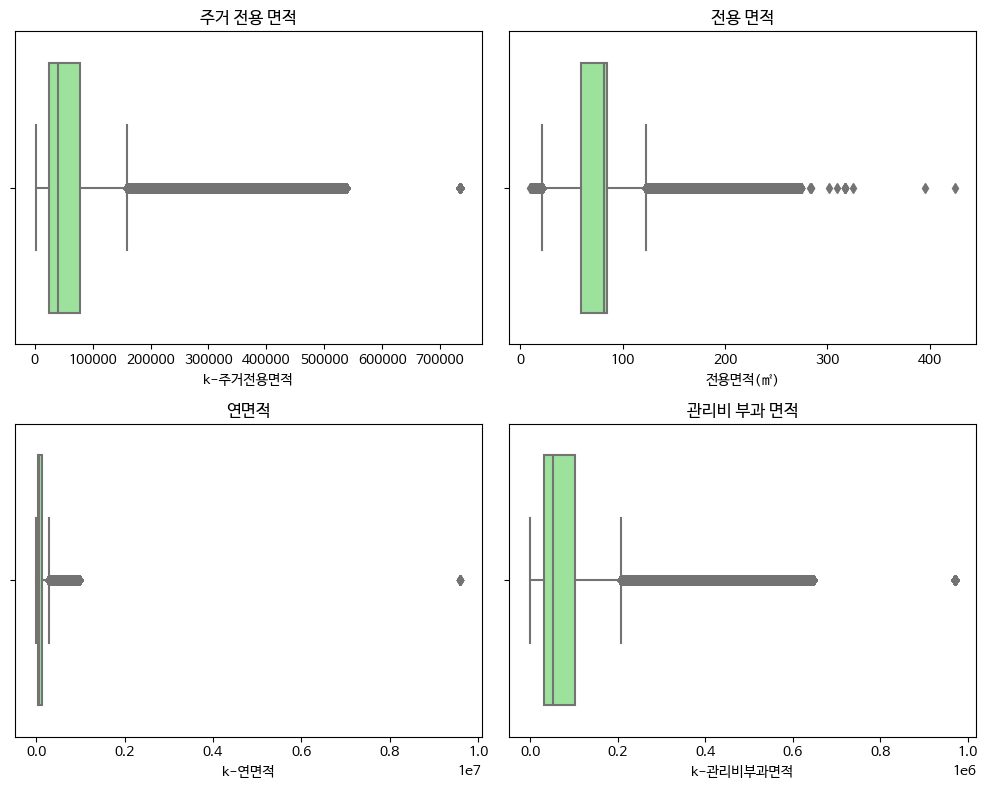

In [20]:
plt.figure(figsize=(10, 8))

plt.subplot(2, 2, 1)
sns.boxplot(data=train_df, x='k-주거전용면적', color='lightgreen')
plt.title('주거 전용 면적')

plt.subplot(2, 2, 2)
sns.boxplot(data=train_df, x='전용면적(㎡)', color='lightgreen')
plt.title('전용 면적')

plt.subplot(2, 2, 3)
sns.boxplot(data=train_df, x='k-연면적', color='lightgreen')
plt.title('연면적')

plt.subplot(2, 2, 4)
sns.boxplot(data=train_df, x='k-관리비부과면적', color='lightgreen')
plt.title('관리비 부과 면적')


plt.tight_layout()
plt.show()

In [21]:
# 이상치 제거 방법에는 IQR을 이용
def IQR(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    return lower, upper

In [22]:
lower, upper = IQR(train_df, '전용면적(㎡)')
train_df = train_df[(train_df['전용면적(㎡)'] > lower) & (train_df['전용면적(㎡)'] < upper)]

In [23]:
# '시군구' 제거(시, 구, 동으로 분리했기 때문에)
train_df.drop('시군구', axis=1, inplace=True)
test_df.drop('시군구', axis=1, inplace=True)

In [24]:
train_df['k-건설사(시공사)'].unique()
test_df['k-건설사(시공사)'].unique()

array(['우성건설', '포스코', '대한주택공사', '현대건설(주)', '삼성물산', '동양고속건설주식회사', '대우건설',
       '삼성물산주식회사', '현대,쌍용,GS', '쌍용건설(주)', '삼성물산(주)', '현대산업개발', '한보',
       'NULL', '중앙건설', '태영건설', '신동아건설', '고려개발(주)', '대우건설,대림산업,태영건설',
       '삼성건설', 'GS건설', '(주)한화건설', '한신공영', '(주)건영,삼익주택,라이프주택', '계룡건설산업(주)',
       '한양수자인', '두산건설', '계룡건설(주)', '동부건설', '고속도로관리공단', '동부건설(주)외1',
       '(주)대우건설', '청광종합건설(주)', '중앙건설(주)', 'LG건설', '롯데건설', '신동아건설(주)',
       '현대산업개발(주)', '(주)청구주택', '삼호건설', '현대,대림', '신동아 건설(주)', '롯데건설(주)',
       '벽산건설', '동부건설(주)', '홍익종합건업(주)', '한양주택 (주)', '성지건설', '남광토건(주)',
       '고려산업개발(주)', 'gs건설', 'KCC', '두산, 이수건설', 'TEC건설', 'SH공사',
       '현대건설,현대산업개발,한진중공업', '코오롱글로벌(주)', '금호건설', '금호', '우림건설(주)', '중앙하이츠',
       '우림건설', '삼환, 삼익건설', '삼성건설(주)', '한화건설', '현대건설', '한일건설', '대림산업(주)',
       '삼성중공업', '주식회사 서희건설', '대호아이피종합건설', '라이프건설', '갑을건설', '현대건설주식회사',
       'SK건설', '우성건설(주)', '고려산업개발', '호반건설', '삼환기업', '대우푸르지오', '(주)롯데건설',
       '(주)태영', '(주)우리건설', '(주)금호건설', 'sh공사', '한진중공업', '대림산업', '(주)중앙건설',
    

In [25]:
# 구글 피셜 국내 탑 건설사 20개
top_construction_companies = [
    '삼성물산', '현대건설', 'GS건설', '대림산업', '한화건설',
    '롯데건설', '대우건설', 'SK건설', '현대산업개발', '건영종합건설',
    '한신공영', '한진중공업', '동부건설', 'LG건설', '두산건설',
    '쌍용건설', '세방기업', '신도건설', '고려산업개발', '현대엔지니어링'
]

train_df['탑급 건설사'] = train_df['k-건설사(시공사)'].apply(lambda x: 1 if x in top_construction_companies else 0)
test_df['탑급 건설사'] = test_df['k-건설사(시공사)'].apply(lambda x: 1 if x in top_construction_companies else 0)

In [26]:
gangnam = ['강서구', '영등포구', '동작구', '서초구', '강남구', '송파구', '강동구']

train_df['강남여부'] = train_df['구'].apply(lambda x: 1 if x in gangnam else 0)
test_df['강남여부'] = test_df['구'].apply(lambda x: 1 if x in gangnam else 0)

In [27]:
num_col = []
cat_col = []

for column in train_df.columns:
    if pd.api.types.is_numeric_dtype(train_df[column]):
        num_col.append(column)
    else:
        cat_col.append(column)

print("연속형 변수:", num_col)
print("범주형 변수:", cat_col)

연속형 변수: ['전용면적(㎡)', '계약년월', '계약일', '층', '건축년도', 'k-전체동수', 'k-전체세대수', 'k-연면적', 'k-주거전용면적', 'k-관리비부과면적', 'k-전용면적별세대현황(60㎡이하)', 'k-전용면적별세대현황(60㎡~85㎡이하)', 'k-85㎡~135㎡이하', '건축면적', '주차대수', '좌표X', '좌표Y', 'target', '탑급 건설사', '강남여부']
범주형 변수: ['번지', '본번', '부번', '아파트명', '도로명', 'k-단지분류(아파트,주상복합등등)', 'k-세대타입(분양형태)', 'k-관리방식', 'k-복도유형', 'k-난방방식', 'k-건설사(시공사)', 'k-시행사', 'k-사용검사일-사용승인일', 'k-수정일자', '경비비관리형태', '세대전기계약방법', '청소비관리형태', '기타/의무/임대/임의=1/2/3/4', '단지승인일', '사용허가여부', '관리비 업로드', '단지신청일', '시', '구', '동']


In [28]:
num_col = []
cat_col = []

for column in test_df.columns:
    if pd.api.types.is_numeric_dtype(test_df[column]):
        num_col.append(column)
    else:
        cat_col.append(column)

print("연속형 변수:", num_col)
print("범주형 변수:", cat_col)

연속형 변수: ['전용면적(㎡)', '계약년월', '계약일', '층', '건축년도', 'k-전체동수', 'k-전체세대수', 'k-연면적', 'k-주거전용면적', 'k-관리비부과면적', 'k-전용면적별세대현황(60㎡이하)', 'k-전용면적별세대현황(60㎡~85㎡이하)', 'k-85㎡~135㎡이하', '건축면적', '주차대수', '좌표X', '좌표Y', '탑급 건설사', '강남여부']
범주형 변수: ['번지', '본번', '부번', '아파트명', '도로명', 'k-단지분류(아파트,주상복합등등)', 'k-세대타입(분양형태)', 'k-관리방식', 'k-복도유형', 'k-난방방식', 'k-건설사(시공사)', 'k-시행사', 'k-사용검사일-사용승인일', 'k-수정일자', '경비비관리형태', '세대전기계약방법', '청소비관리형태', '기타/의무/임대/임의=1/2/3/4', '단지승인일', '사용허가여부', '관리비 업로드', '단지신청일', '시', '구', '동']


In [29]:
# 범주형 데이터 라벨인코딩
encoder = LabelEncoder()
for column in cat_col:
    train_df[column] = encoder.fit_transform(train_df[column])
    
for column in cat_col:
    test_df[column] = encoder.fit_transform(test_df[column])    

In [30]:
test_df['target'] = 0

In [31]:
test_df.head()

,번지,본번,부번,아파트명,전용면적(㎡),계약년월,계약일,층,건축년도,도로명,"k-단지분류(아파트,주상복합등등)",k-세대타입(분양형태),k-관리방식,k-복도유형,k-난방방식,k-전체동수,k-전체세대수,k-건설사(시공사),k-시행사,k-사용검사일-사용승인일,k-연면적,k-주거전용면적,k-관리비부과면적,k-전용면적별세대현황(60㎡이하),k-전용면적별세대현황(60㎡~85㎡이하),k-85㎡~135㎡이하,k-수정일자,경비비관리형태,세대전기계약방법,청소비관리형태,건축면적,주차대수,기타/의무/임대/임의=1/2/3/4,단지승인일,사용허가여부,관리비 업로드,좌표X,좌표Y,단지신청일,시,구,동,탑급 건설사,강남여부,target
0,1412,865,1,137,79.9700,202307,26,5,1987,1765,3,2,2,1,1,8.0,270.0,190,168,24,22637.0,20204.0,22637.0,20.0,250.0,0.0,160,4,1,4,4858.00,262.0,4,559,1,0,127.057210,37.476763,201,0,0,6,0,1,0
1,1402,858,1,138,108.2017,202308,15,10,2021,101,3,2,1,1,4,2.0,232.0,224,60,521,44951.0,24878.0,31174.0,0.0,0.0,232.0,162,2,2,2,2724.46,305.0,2,555,1,0,127.056394,37.484892,197,0,0,6,0,1,0
2,1403,859,0,142,161.0000,202307,28,15,1984,100,3,2,2,5,4,5.0,405.0,190,303,15,63304.0,53437.0,61064.0,0.0,0.0,285.0,157,4,1,2,61064.24,419.0,2,1,1,0,127.055990,37.483894,16,0,0,6,0,1,0
3,1403,859,0,142,133.4600,202308,10,14,1984,100,3,2,2,5,4,5.0,405.0,190,303,15,63304.0,53437.0,61064.0,0.0,0.0,285.0,157,4,1,2,61064.24,419.0,2,1,1,0,127.055990,37.483894,16,0,0,6,0,1,0
4,1403,859,0,142,104.4300,202308,18,6,1984,100,3,2,2,5,4,5.0,405.0,190,303,15,63304.0,53437.0,61064.0,0.0,0.0,285.0,157,4,1,2,61064.24,419.0,2,1,1,0,127.055990,37.483894,16,0,0,6,0,1,0


### model training

In [32]:
y_train = train_df['target']
X_train = train_df.drop(['target'], axis=1)

# 학습 데이터와 검증 데이터를 8:2 비율
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [33]:
def RMSE(y, y_pred):
    rmse = mean_squared_error(y, y_pred) ** 0.5
    return rmse

model_rf = RandomForestRegressor(n_estimators=500, random_state=42)
model_rf.fit(X_train, y_train)
y_pred = model_rf.predict(X_val)
print('RandomForest RMSE :', RMSE(y_val, y_pred))

In [ ]:
%%time
X_test = test_df.drop(['target'], axis=1)

# Test dataset에 대한 inference를 진행합니다.
test_pred = model_xgb.predict(X_test)

CPU times: user 226 ms, sys: 0 ns, total: 226 ms
Wall time: 37.1 ms


In [ ]:
test_pred.shape

(9272,)

In [ ]:
preds_df = pd.DataFrame(test_pred.astype(int), columns=["target"])
preds_df.to_csv('submission2.csv', index=False)